Demand Predict

Basic Data Preparation

In [1]:
from pandas import read_csv
from datetime import datetime

In [2]:
dataset = read_csv('demand.csv')

In [3]:
# manually specify column names
dataset.columns = ['date', 'quantity']
dataset.index.name = 'date'
dataset.head(5)

,date,quantity
date,,
0,2016-01-01,1
1,2016-01-02,2
2,2016-01-03,6
3,2016-01-04,0
4,2016-01-05,0


In [4]:
from matplotlib import pyplot
# load dataset
#dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

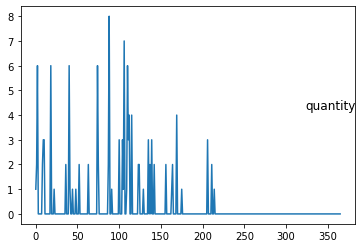

In [5]:

# plot each column
pyplot.figure()
pyplot.plot(values[:, 1])
pyplot.title(dataset.columns[1], y=0.5, loc='right')
pyplot.show()

Multivariate LSTM Forecast Model

LSTM Data Preparation:<br>
***framing the dataset as a supervised learning problem and normalizing the input variables.***

In [6]:
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [7]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [8]:
# integer encode direction
encoder = LabelEncoder()
values[:,0] = encoder.fit_transform(values[:,0])

In [9]:
values

array([[0, 1],
       [1, 2],
       [2, 6],
       [3, 0],
       [4, 0],
       [5, 0],
       [6, 0],
       [7, 0],
       [8, 2],
       [9, 3],
       [10, 3],
       [11, 0],
       [12, 0],
       [13, 0],
       [14, 0],
       [15, 0],
       [16, 0],
       [17, 0],
       [18, 6],
       [19, 0],
       [20, 0],
       [21, 0],
       [22, 1],
       [23, 0],
       [24, 0],
       [25, 0],
       [26, 0],
       [27, 0],
       [28, 0],
       [29, 0],
       [30, 0],
       [31, 0],
       [32, 0],
       [33, 0],
       [34, 0],
       [35, 0],
       [36, 2],
       [37, 0],
       [38, 0],
       [39, 0],
       [40, 6],
       [41, 1],
       [42, 0],
       [43, 0],
       [44, 1],
       [45, 0],
       [46, 0],
       [47, 0],
       [48, 1],
       [49, 0],
       [50, 0],
       [51, 0],
       [52, 2],
       [53, 0],
       [54, 0],
       [55, 0],
       [56, 0],
       [57, 0],
       [58, 0],
       [59, 0],
       [60, 0],
       [61, 0],
       [62, 0],
  

In [10]:
# ensure all data is float
values = values.astype('float32')

In [11]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [12]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [22]:
reframed.head(10)

,var1(t-1),var2(t-1),var1(t),var2(t)
1,0.000000,0.125,0.002740,0.250
2,0.002740,0.250,0.005479,0.750
3,0.005479,0.750,0.008219,0.000
4,0.008219,0.000,0.010959,0.000
5,0.010959,0.000,0.013699,0.000
6,0.013699,0.000,0.016438,0.000
7,0.016438,0.000,0.019178,0.000
8,0.019178,0.000,0.021918,0.250
9,0.021918,0.250,0.024658,0.375
10,0.024658,0.375,0.027397,0.375


In [14]:
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
#print(reframed.head())

In [49]:
values = reframed.values
values

array([[0.        , 0.125     , 0.00273973, 0.25      ],
       [0.00273973, 0.25      , 0.00547945, 0.75      ],
       [0.00547945, 0.75      , 0.00821918, 0.        ],
       ...,
       [0.9917809 , 0.        , 0.99452055, 0.        ],
       [0.99452055, 0.        , 0.9972603 , 0.        ],
       [0.9972603 , 0.        , 1.        , 0.        ]], dtype=float32)

Define and Fit Model

In [64]:
import math
# split into train and test sets
values = reframed.values
n_train_day = math.floor(365 *0.8)
train = values[:n_train_day,:]
test = values[n_train_day:, :]

In [65]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [66]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(292, 1, 3) (292,) (73, 1, 3) (73,)


In [67]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [74]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(2))
model.compile(loss='mae', optimizer='adam')

In [75]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
5/5 - 0s - loss: 0.0702 - val_loss: 0.0369
Epoch 2/50
5/5 - 0s - loss: 0.0648 - val_loss: 0.0262
Epoch 3/50
5/5 - 0s - loss: 0.0605 - val_loss: 0.0123
Epoch 4/50
5/5 - 0s - loss: 0.0595 - val_loss: 0.0104
Epoch 5/50
5/5 - 0s - loss: 0.0614 - val_loss: 0.0071
Epoch 6/50
5/5 - 0s - loss: 0.0585 - val_loss: 0.0075
Epoch 7/50
5/5 - 0s - loss: 0.0581 - val_loss: 0.0084
Epoch 8/50
5/5 - 0s - loss: 0.0561 - val_loss: 0.0083
Epoch 9/50
5/5 - 0s - loss: 0.0549 - val_loss: 0.0039
Epoch 10/50
5/5 - 0s - loss: 0.0550 - val_loss: 0.0018
Epoch 11/50
5/5 - 0s - loss: 0.0545 - val_loss: 0.0033
Epoch 12/50
5/5 - 0s - loss: 0.0530 - val_loss: 0.0014
Epoch 13/50
5/5 - 0s - loss: 0.0524 - val_loss: 6.9129e-04
Epoch 14/50
5/5 - 0s - loss: 0.0531 - val_loss: 9.9381e-04
Epoch 15/50
5/5 - 0s - loss: 0.0523 - val_loss: 6.4246e-04
Epoch 16/50
5/5 - 0s - loss: 0.0525 - val_loss: 0.0023
Epoch 17/50
5/5 - 0s - loss: 0.0522 - val_loss: 9.1625e-04
Epoch 18/50
5/5 - 0s - loss: 0.0526 - val_loss: 7.3392e-04

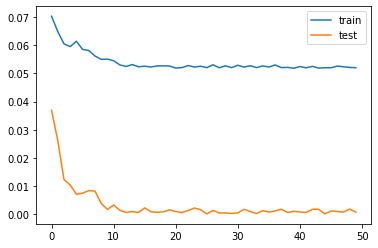

In [76]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Evaluate Model

In [77]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [78]:
from numpy import concatenate
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

ValueError: operands could not be broadcast together with shapes (73,4) (2,) (73,4) 

In [79]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

ValueError: operands could not be broadcast together with shapes (73,3) (2,) (73,3) 

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
!pip install keras

In [ ]:
!pip install tensorflow